#### Laboratorio No.3

In [109]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import mypreprocessors as mypp #nuestra librerías de transformaciones.

import joblib

##### Importar el dataset

In [26]:
dataHP = pd.read_csv('train.csv')
dataHP.shape
print(dataHP.columns)

Index(['id', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


##### Clasificamos las columnas del dataset en continuas, discretas y categoricas.

In [9]:
dataset=dataHP
def getColumnTypes(dataset):
    '''Esta función extrae el tipo de dominio de las columnas de un dataset
    Entradas: Pandas Dataframe
    Salida: Tupla con arreglo que contiene nombres de las columnas'''
    continuas= []
    discretas = []
    categoricas = []
    for col in dataset.columns:
        if(dataset[col].dtypes=='int64' or (dataset[col].dtype=='float64')):
            if(len(dataset[col].unique())>30):
               continuas.append(col)
            else:
               discretas.append(col)
        else: 
               categoricas.append(col) 
    return continuas, discretas, categoricas   

In [10]:
## Vemos cuales son las variables continuas 
continuas, discretas, categoricas = getColumnTypes(dataHP)
print(continuas)
print(discretas)
print(categoricas) 

['id', 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
[]
['ocean_proximity']


##### Vamos a revisar las columnas con NAN y su porcentaje 

In [51]:
def data_faltante(dataHP):
    prop_nan_por_col = dataHP.isnull().mean() * 100 
    return prop_nan_por_col

data_faltante = data_faltante(dataHP)
print(data_faltante)


id                    0.000000
longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.948294
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


#### Aplicamos CCA (Complete Case Analysis) 

In [52]:
def drop_nan_rows(dataHP, columns):
    """Función que elimina las filas con valores faltantes en las columnas especificadas"""
    dataHP = dataHP.dropna(subset=columns)
    return dataHP
columns = ['total_bedrooms']  # Modify this as needed
dataHP_clean = drop_nan_rows(dataHP, columns)
print(dataHP_clean.isnull().mean())


id                    0.0
longitude             0.0
latitude              0.0
housing_median_age    0.0
total_rooms           0.0
total_bedrooms        0.0
population            0.0
households            0.0
median_income         0.0
median_house_value    0.0
ocean_proximity       0.0
dtype: float64


In [ ]:
dataHP.shape, dataHP_clean.shape

((14447, 11), (14310, 11))

<AxesSubplot:>

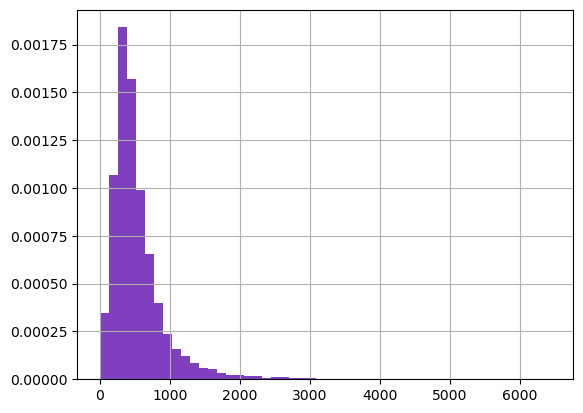

In [57]:
#Implicaciones del CCA
dataHP['total_bedrooms'].hist(bins=50,density=True,color='red',alpha=0.5)
dataHP_clean['total_bedrooms'].hist(bins=50,density=True,color='blue',alpha=0.5)

#### Variable Categorica 

In [58]:
import seaborn as sns

def plot_density(dataframe, column):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    colors = sns.color_palette('bright', n_colors=len(dataframe[column].unique()))

    for i, value in enumerate(dataframe[column].unique()):
        sns.kdeplot(dataframe[dataframe[column] == value]['median_house_value'], shade=True, ax=ax, label=value, color=colors[i])

    ax.set_xlabel('median_house_value')
    ax.set_ylabel('Densidad')
    ax.set_title(f'{column}')
    ax.legend()
    plt.show()

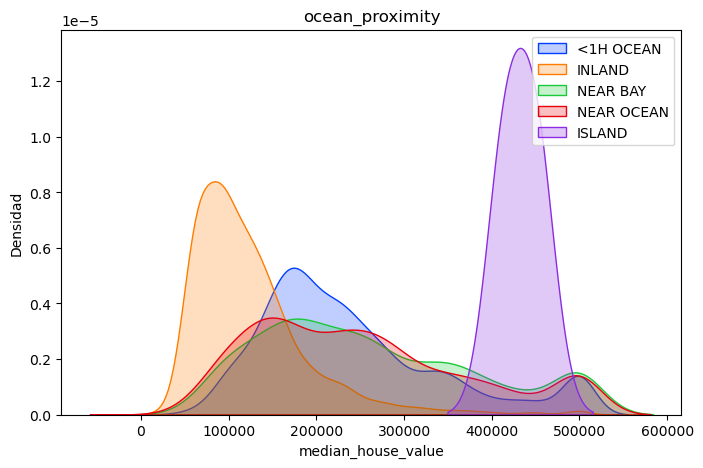

In [59]:
for col in ['ocean_proximity']:
    plot_density(dataHP, col)

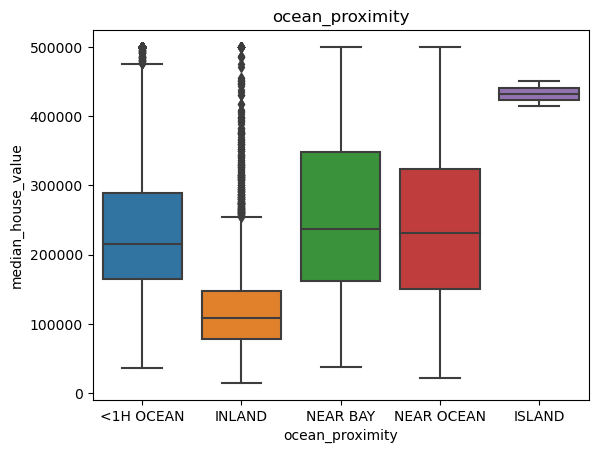

In [63]:
import seaborn as sns 

cat_cols = ['ocean_proximity']
data_cat = dataHP[cat_cols]

def plot_boxplot(dataHP, column):
    sns.boxplot(x=dataHP[column], y=dataHP['median_house_value'])
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('median_house_value')
    plt.show()

for col in cat_cols:
    plot_boxplot(dataHP, col)

### Metodo de Codificación de Variables Categoricas. 

In [64]:
def getCategoryVars(dataHP):
    cat_colnames = []
    colnames = dataset.columns
    for col in colnames: 
        if(dataHP[col].dtype=='object'): 
            cat_colnames.append(col) 
    return cat_colnames

In [65]:
cat_cols = getCategoryVars(dataHP)
cat_cols

['ocean_proximity']

In [67]:
cat_cols.append('median_house_value')
dataset_categories=dataHP[cat_cols]
dataset_categories.head()

,ocean_proximity,median_house_value,median_house_value
0,<1H OCEAN,227500.0,227500.0
1,INLAND,65800.0,65800.0
2,<1H OCEAN,500001.0,500001.0
3,NEAR BAY,225000.0,225000.0
4,<1H OCEAN,272900.0,272900.0


In [68]:
dataset_categories['ocean_proximity'].value_counts()

<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64

#### Frequency Encoding 

In [70]:
#Hacemos un diccionario para poder asignar a cada distribución un codigo. 
ocean_proximity_freq_mapper = (dataset_categories['ocean_proximity'].value_counts().sort_values(ascending=False))

In [117]:
#Asignamos el código a cada distribución de las variables categoricas. 
dataset_categories['ocean_proximity_code']=dataset_categories['ocean_proximity'].map(ocean_proximity_freq_mapper)
dataset_categories[['ocean_proximity','ocean_proximity_code']]
# Imprimir los resultados para cada columna
print('ocean_proximity:')
print(dataset_categories[['ocean_proximity', 'ocean_proximity_code']]).unique



ocean_proximity:
      ocean_proximity  ocean_proximity_code
0           <1H OCEAN                  6384
1              INLAND                  4577
2           <1H OCEAN                  6384
3            NEAR BAY                  1619
4           <1H OCEAN                  6384
...               ...                   ...
14442        NEAR BAY                  1619
14443      NEAR OCEAN                  1865
14444          INLAND                  4577
14445          INLAND                  4577
14446       <1H OCEAN                  6384

[14447 rows x 2 columns]


C:\Users\Franz Castillo\AppData\Local\Temp\ipykernel_17488\1537649313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_categories['ocean_proximity_code']=dataset_categories['ocean_proximity'].map(ocean_proximity_freq_mapper)


AttributeError: 'NoneType' object has no attribute 'unique'

#### Detección de Outliers.

In [79]:

##Creamos función para detectar outliers. 
dataset =dataHP
col='median_house_value'
def plotDistBoxQQ(dataset,col):
    '''
    Descripción: Muestra las graficas de distribución, Boxplot y QQ-Plot para detectar outliers
    Input: dataset -> pandas dataframe, col -> string con nombre de columna. 
    Output: Visualización de plots.
    '''
    
    plt.figure(figsize=(20,6))

    plt.subplot(1,3,1)
    sns.distplot(dataset[col],bins=30)
    plt.title("Histograma y Densidad")

    plt.subplot(1,3,2)
    sns.boxplot(y=dataset[col])
    plt.title("Boxplot")

    plt.subplot(1,3,3)
    stats.probplot(dataset[col],dist="norm",plot=plt)
    plt.title("Boxplot")

C:\Users\Franz Castillo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Franz Castillo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Franz Castillo\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\Franz Castillo\anaconda3\lib\si

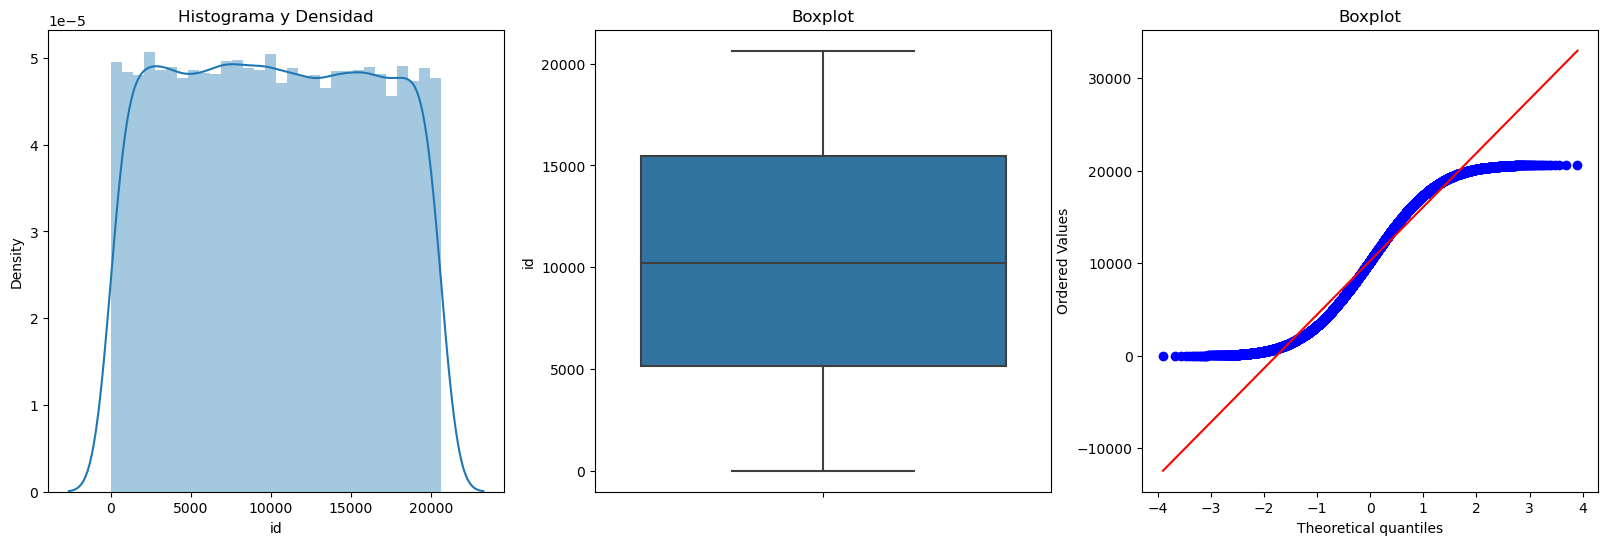

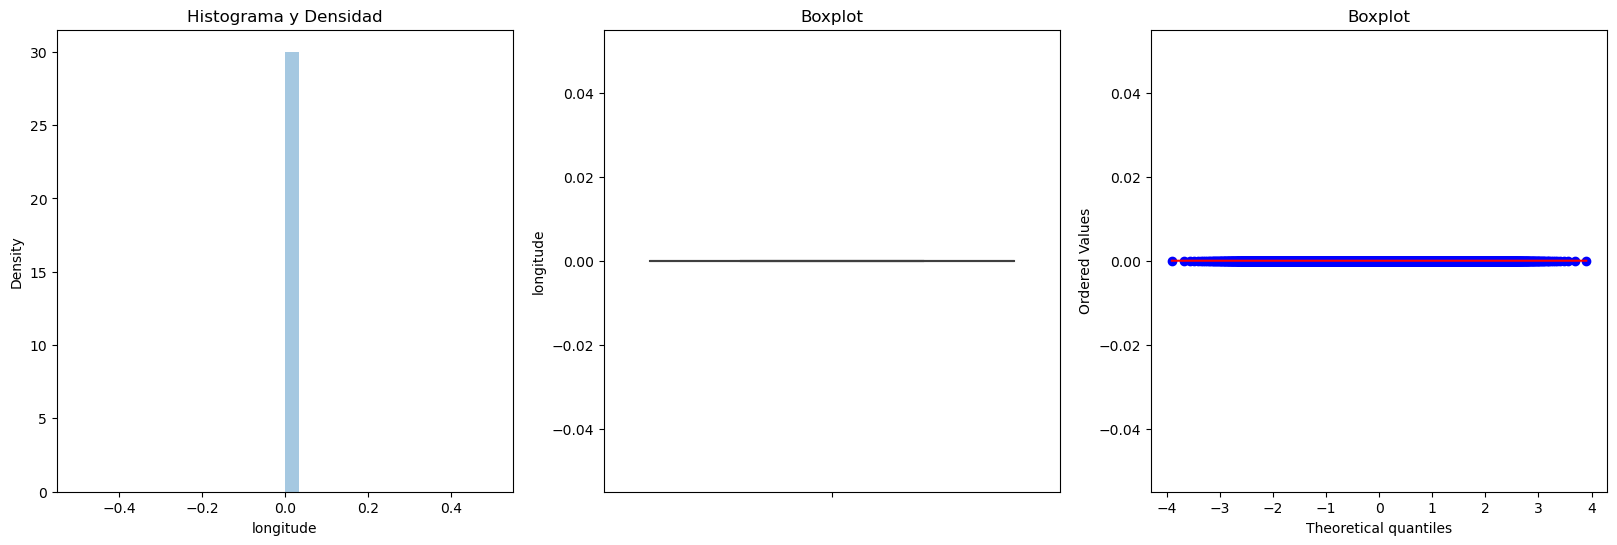

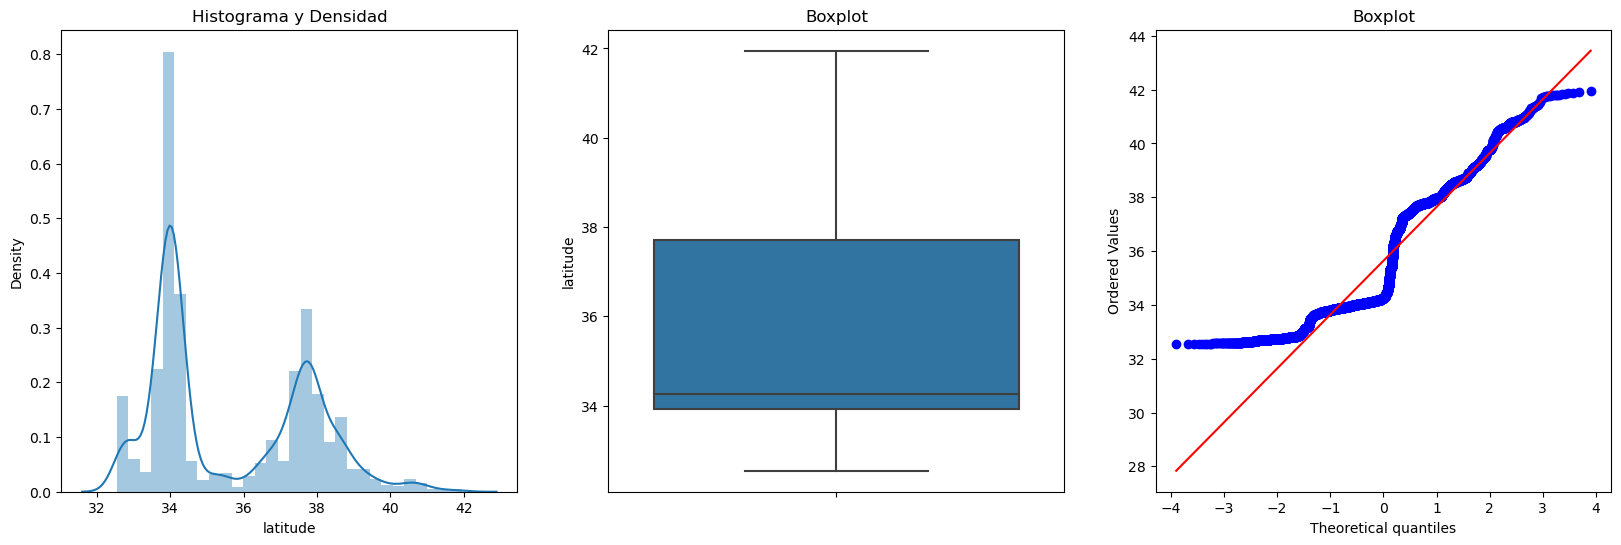

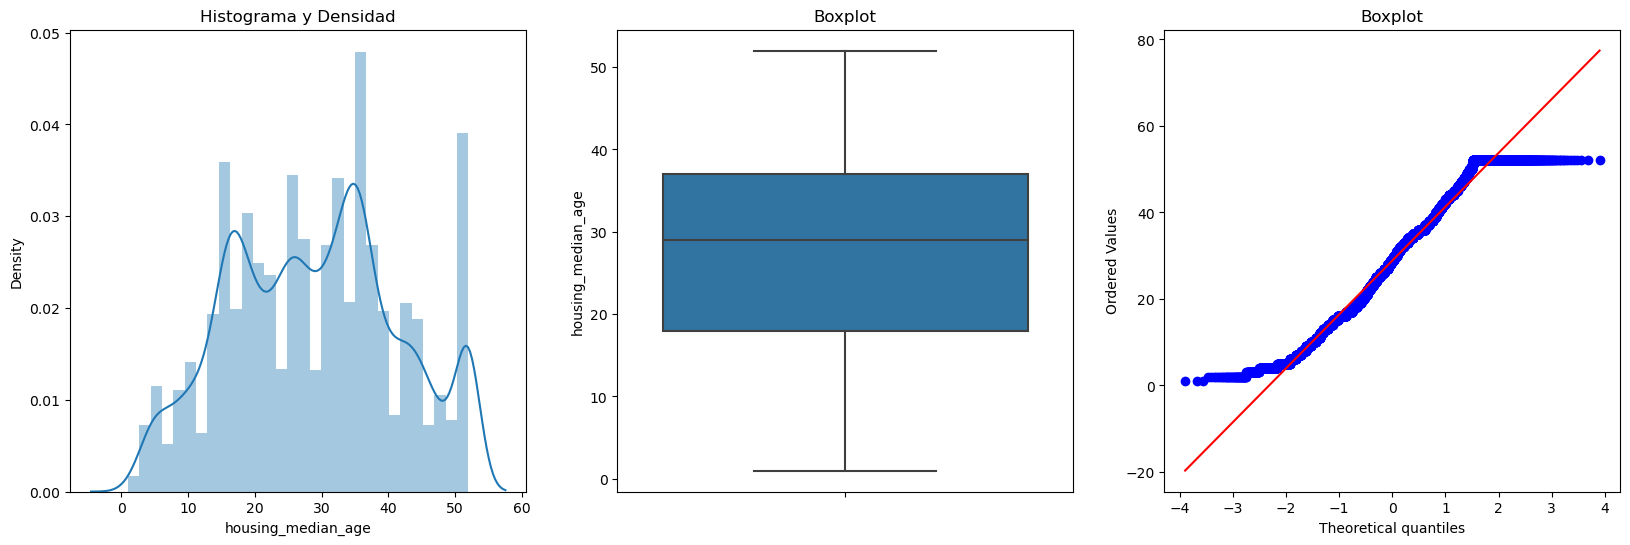

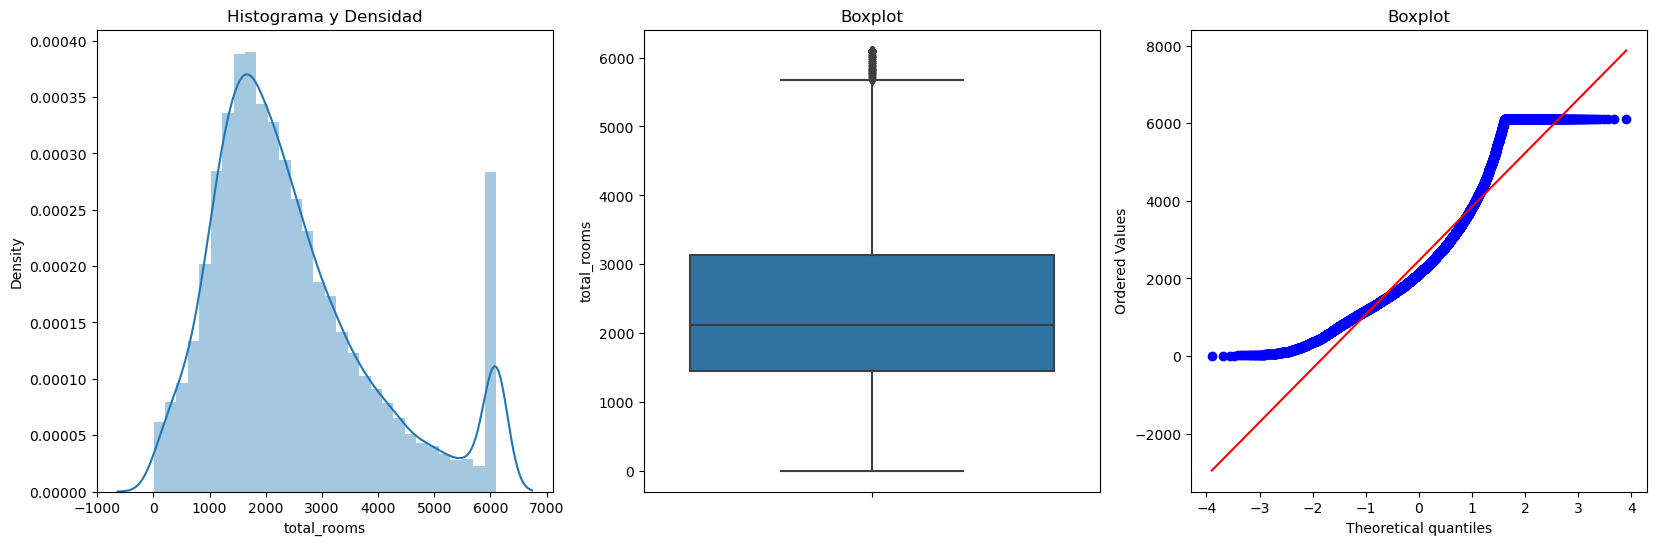

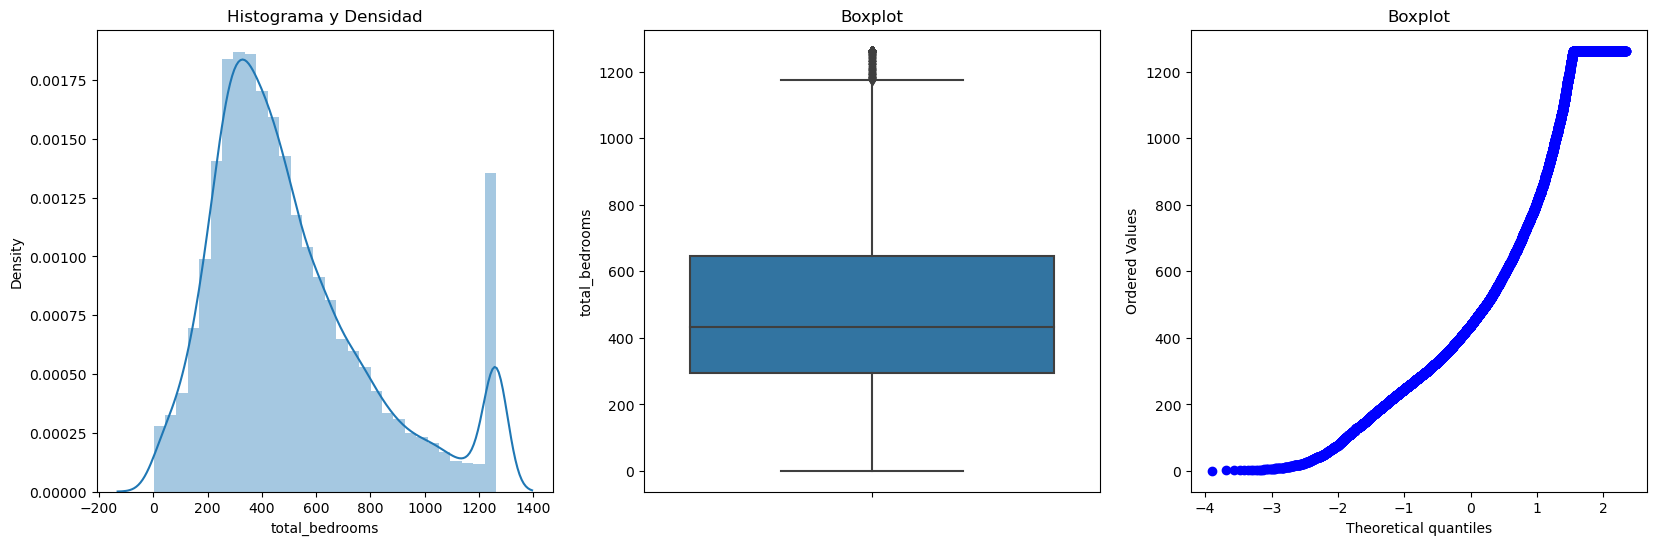

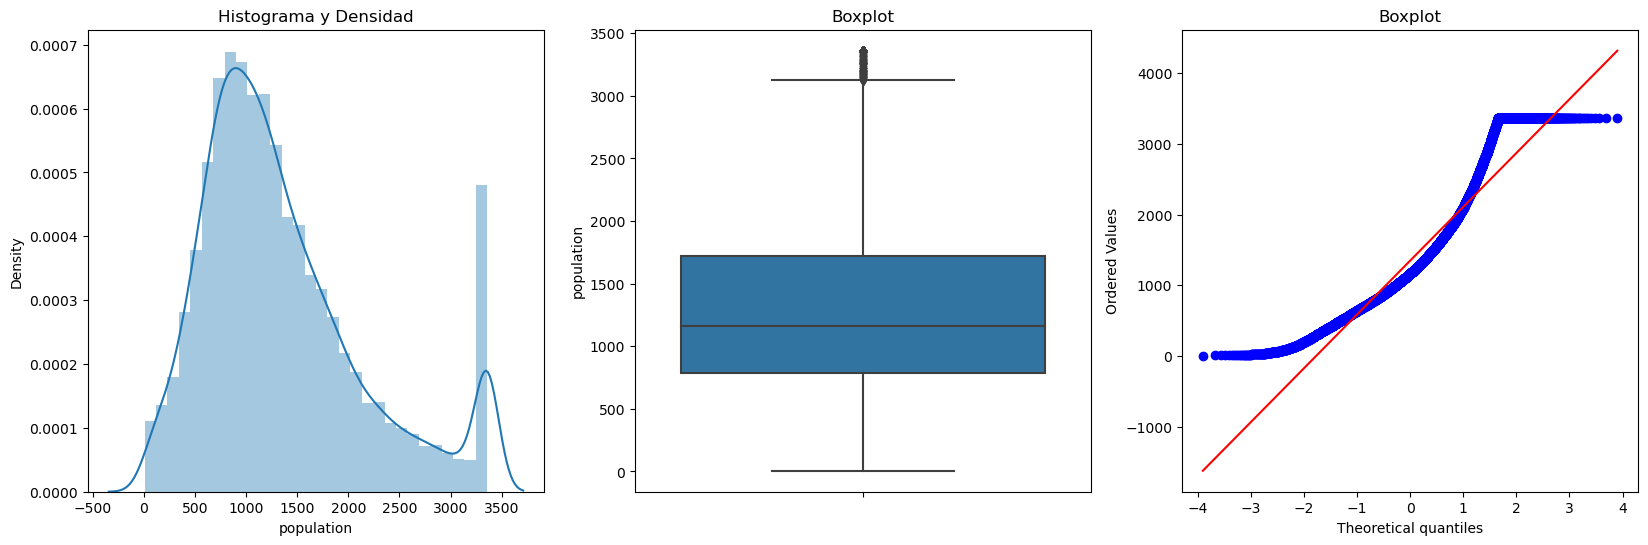

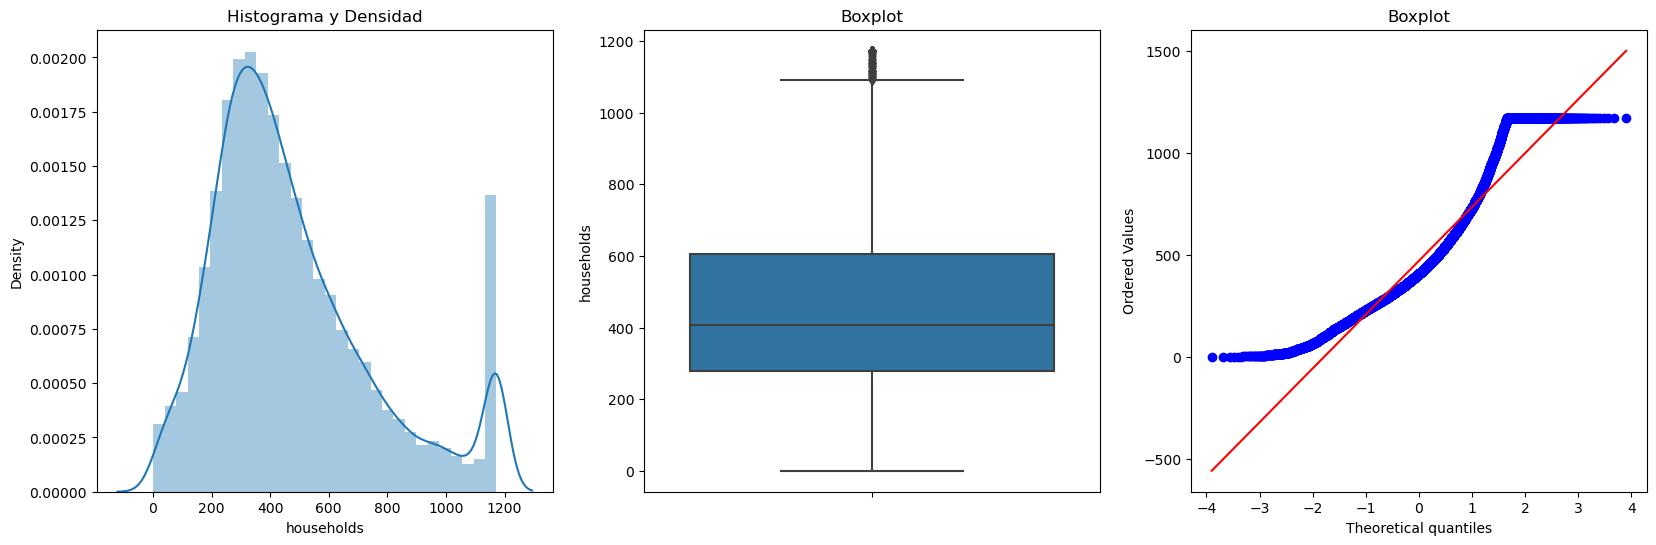

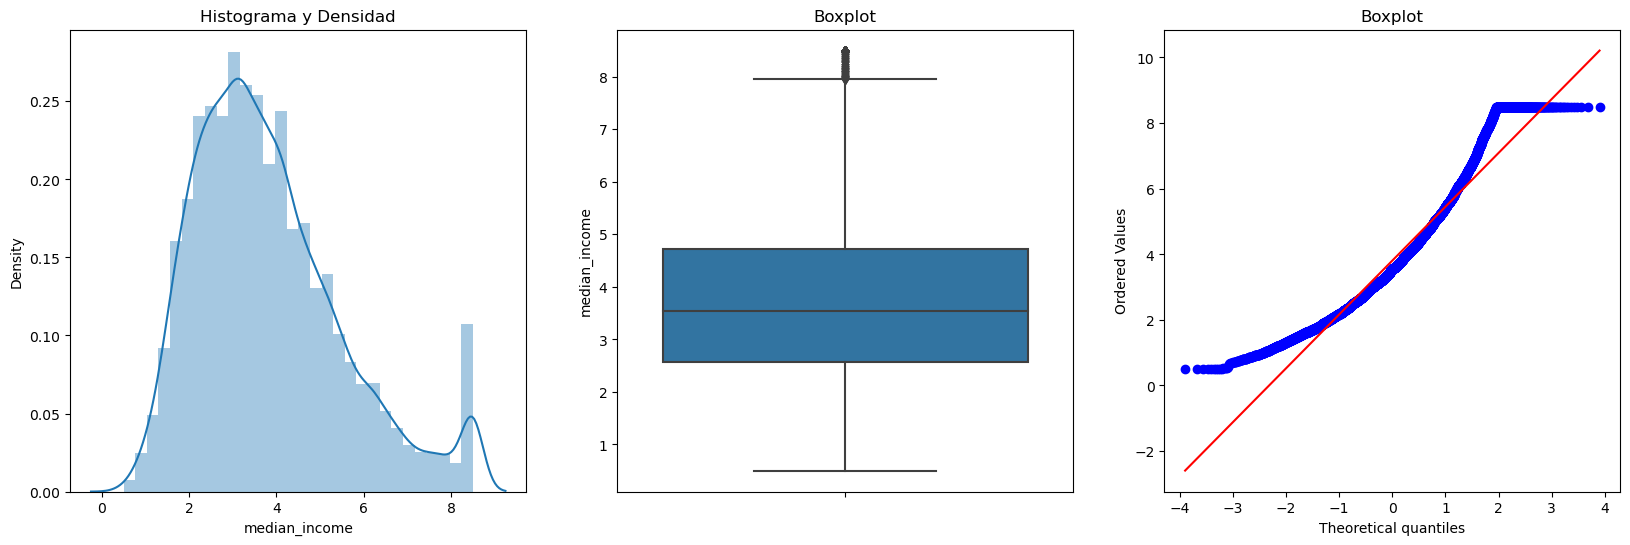

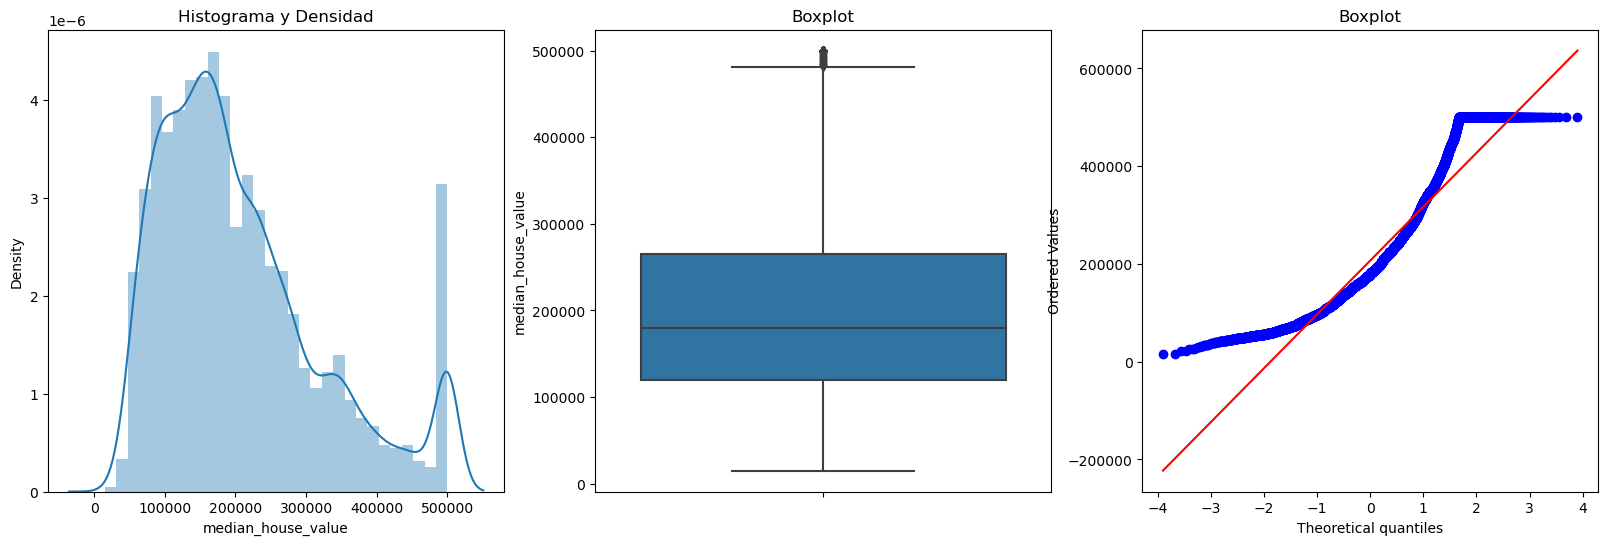

In [94]:
for col in continuas: 
    plotDistBoxQQ(dataHP,col)

In [89]:
## Creamos función para calcular el IQR, Limite inferior y limite superior. 

dataset = dataHP
col = 'longitude' 
def detectOutliersLimits(dataset,col):
    '''
    Descripción: Calcula los limites superiores e inferiores para detección de outliers. 
    Input: dataset->pandas dataframe, col->string nombre de columna
    Output: tupla de floats con los limites superior e inferior (LI,LS)
    '''
    IQR = dataset[col].quantile(0.75)-dataset[col].quantile(0.25)
    LI = dataset[col].quantile(0.25) - (IQR*1.75)
    LS = dataset[col].quantile(0.75) + (IQR*1.75)
    
    return LI,LS

In [90]:
def cappingContinuas(dataset):
    '''
    Descripción: Aplica capping a las variables continuas y convierte los valores negativos a cero.
    No se aplicará esta conversión a las columnas especificadas en cols_no_neg.
    Input: dataset -> pandas dataframe
    Output: pandas dataframe con las variables continuas cappeadas y valores negativos convertidos a cero
    '''
    continuas, _, _ = getColumnTypes(dataset)
    cols_no_neg = ['longitude']  
    for col in continuas:
        if col not in cols_no_neg:
            LI, LS = detectOutliersLimits(dataset, col)
            dataset[col] = np.where(dataset[col] > LS, LS,
                                    np.where(dataset[col] < LI, LI, dataset[col]))
            dataset[col] = np.where(dataset[col] < 0, 0, dataset[col])  # Convertir valores negativos a cero. 
        else:
            LI, LS = detectOutliersLimits(dataset, col)
            dataset[col] = np.where(dataset[col] > LS, LS,
                                    np.where(dataset[col] < LI, LI, dataset[col]))
    return dataset


In [91]:
dataHP_capped = cappingContinuas(dataHP)

C:\Users\Franz Castillo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Franz Castillo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Franz Castillo\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\Franz Castillo\anaconda3\lib\si

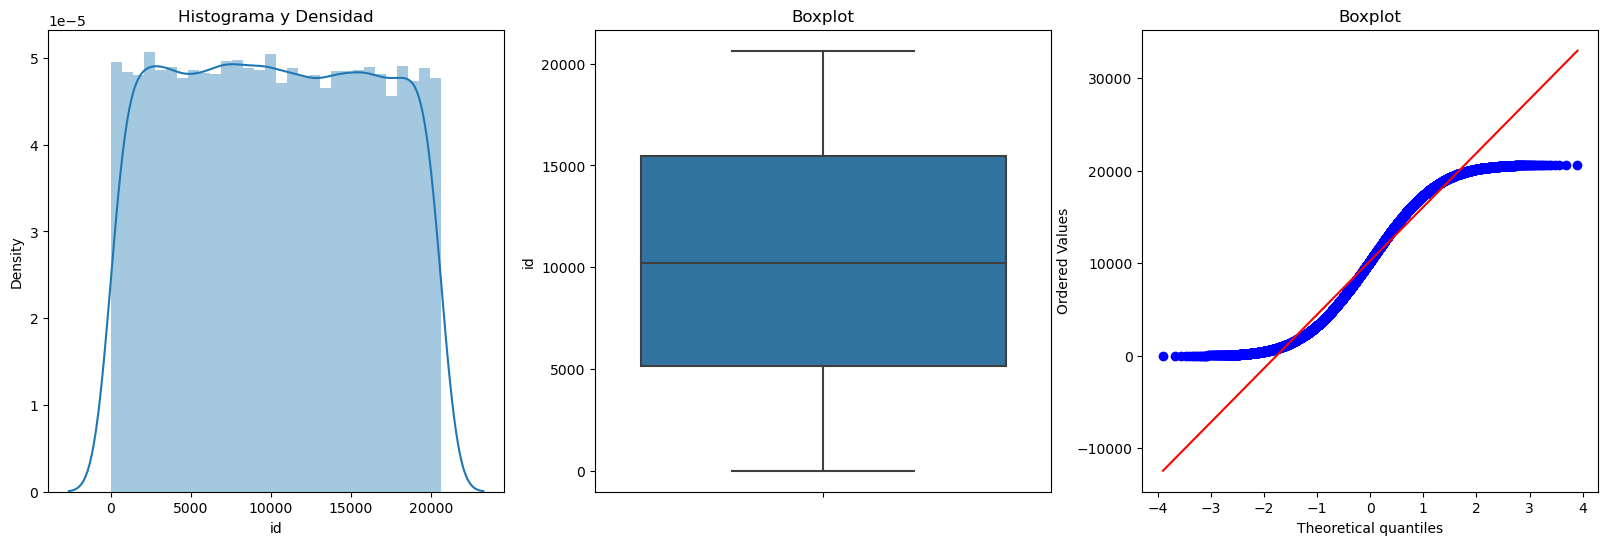

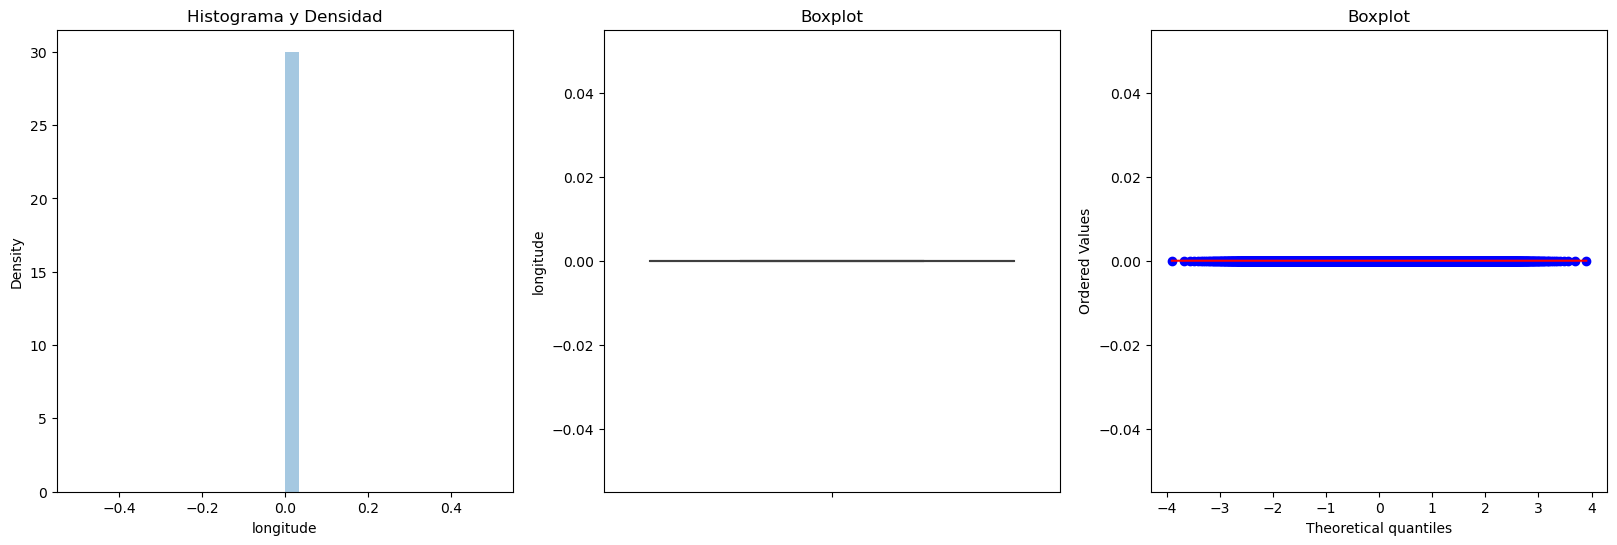

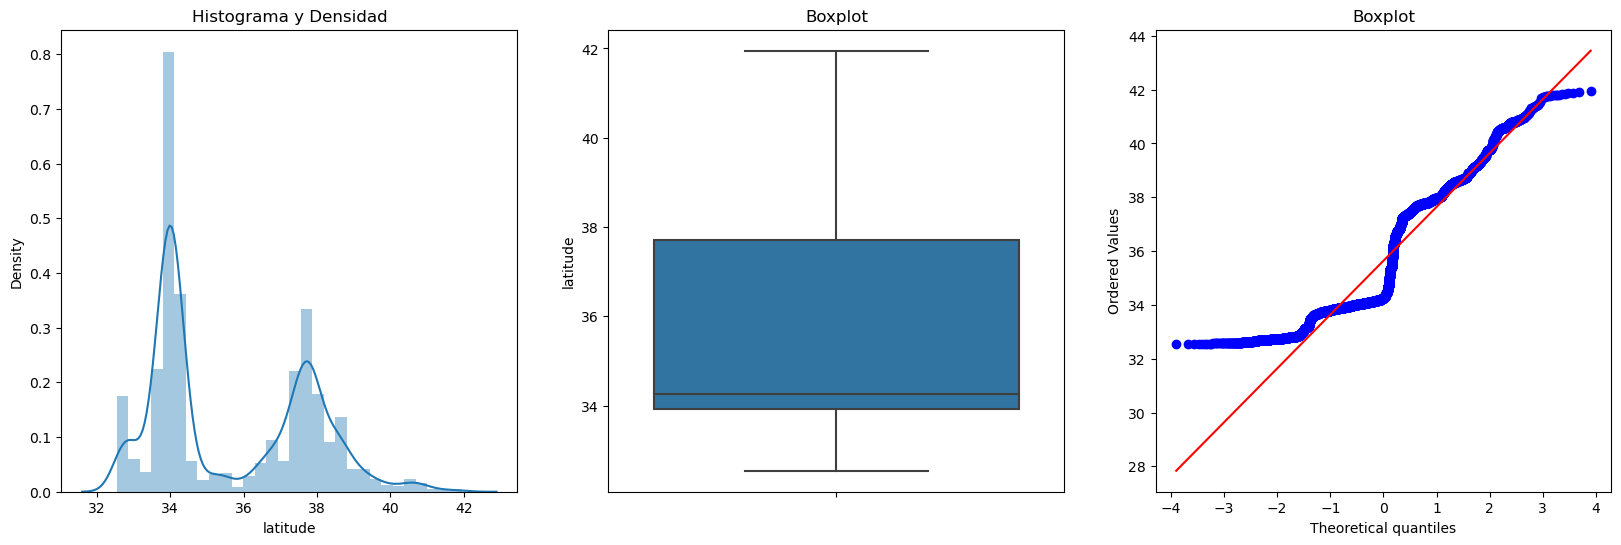

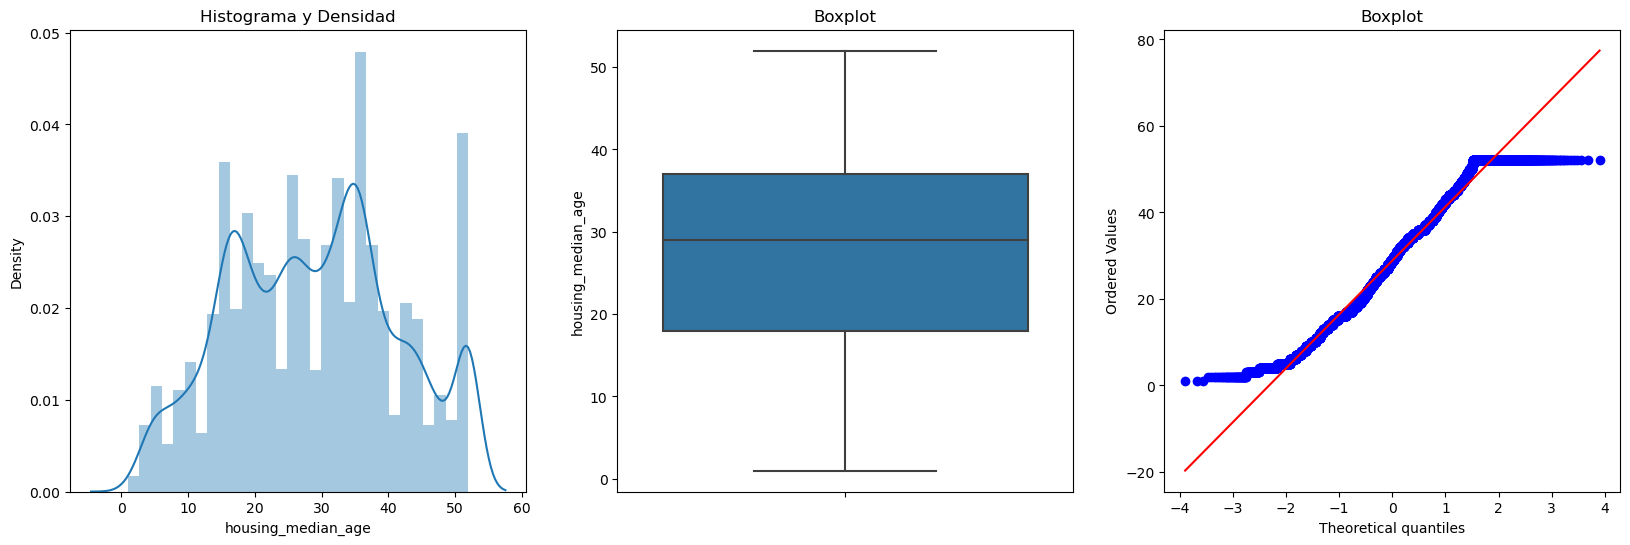

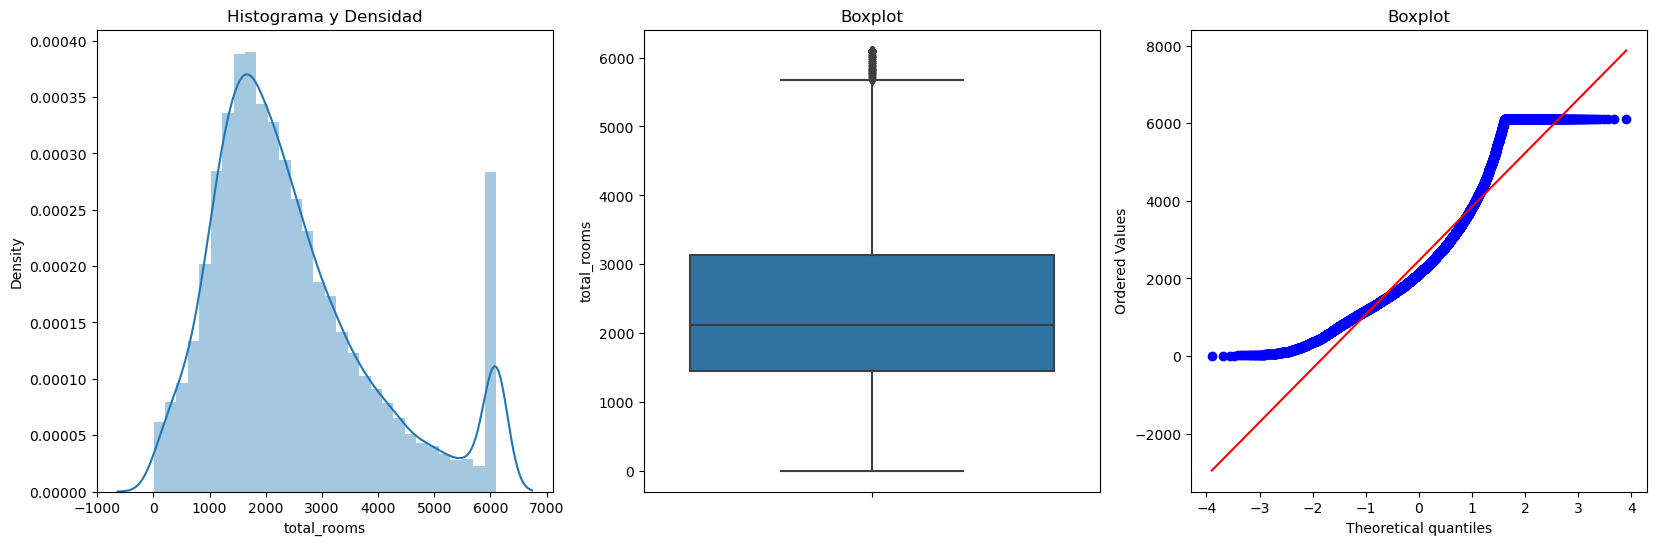

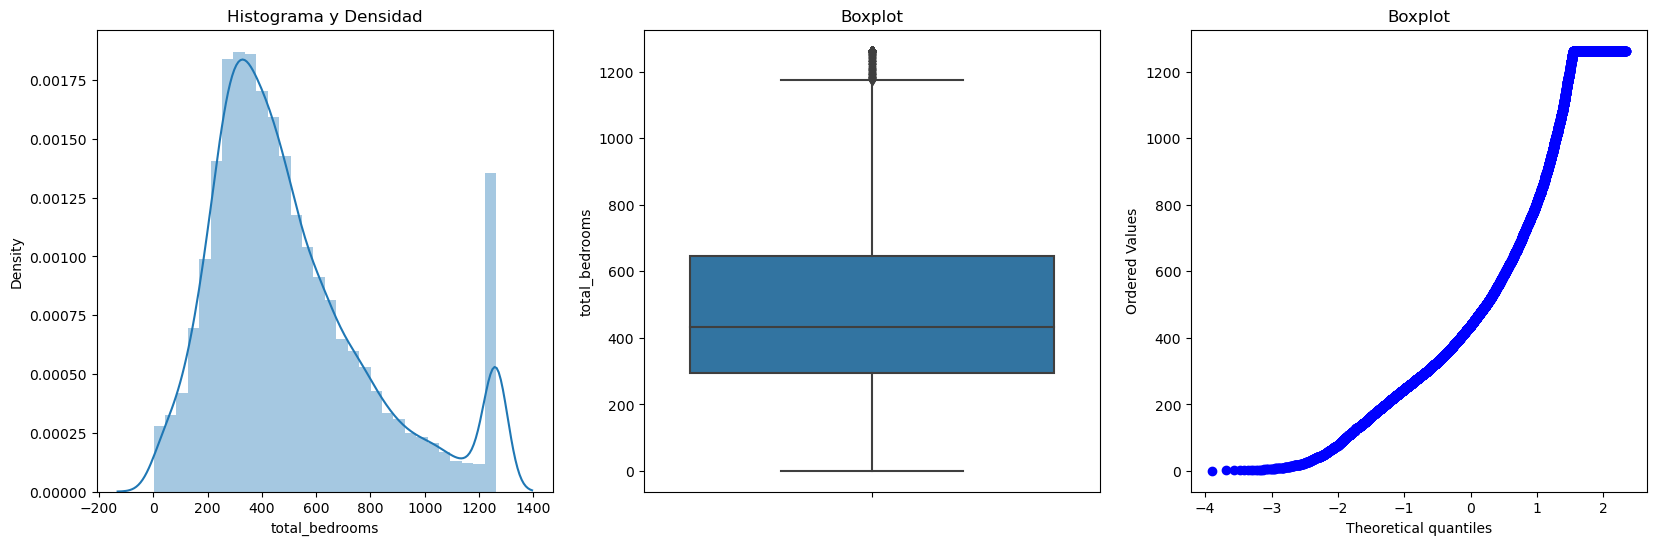

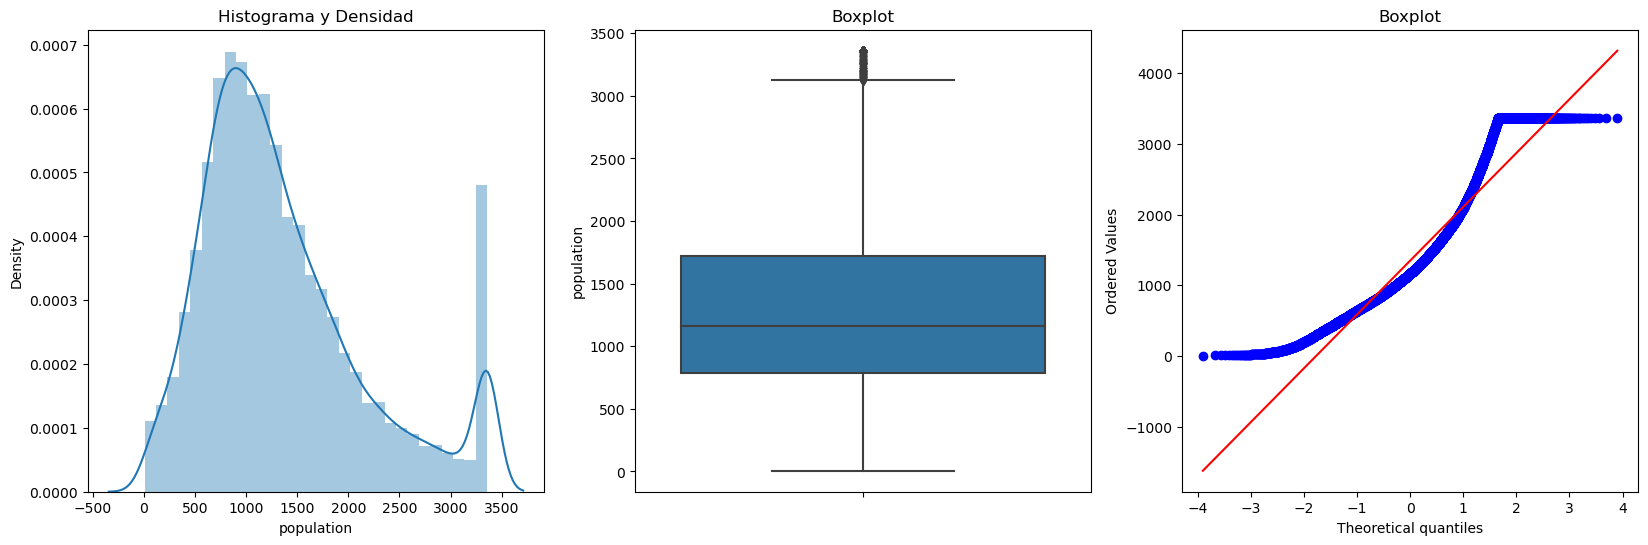

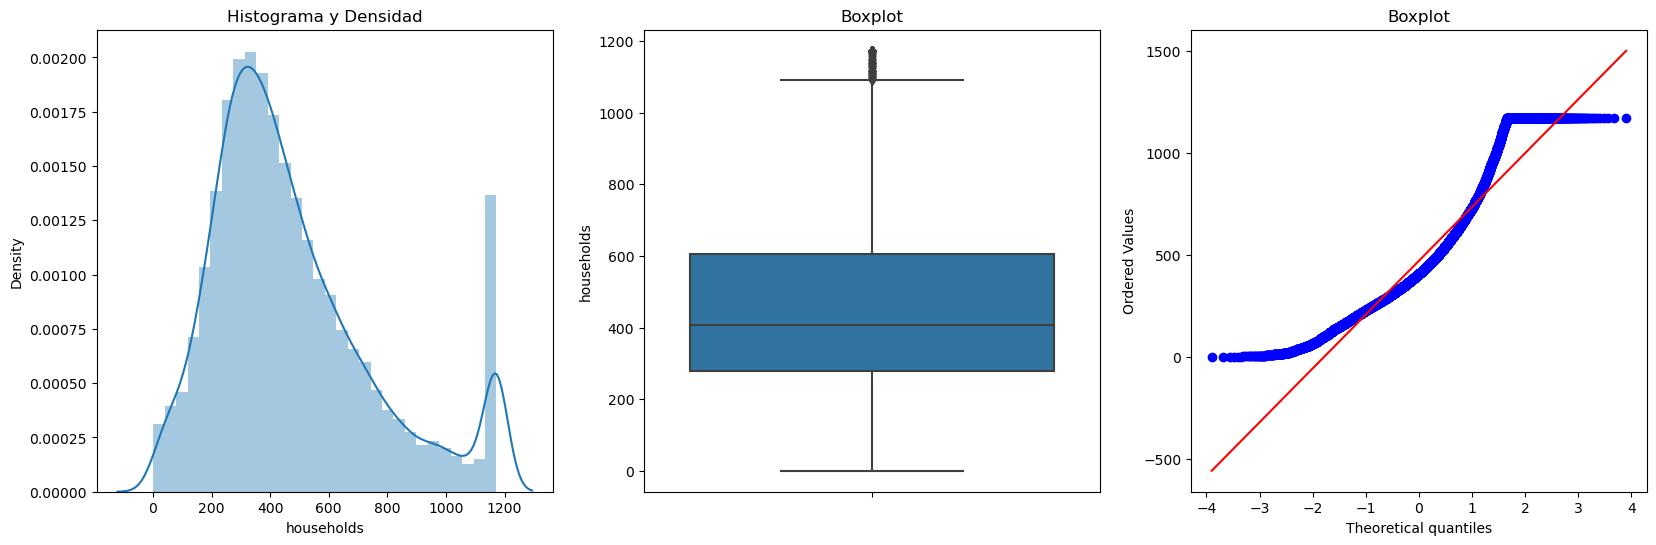

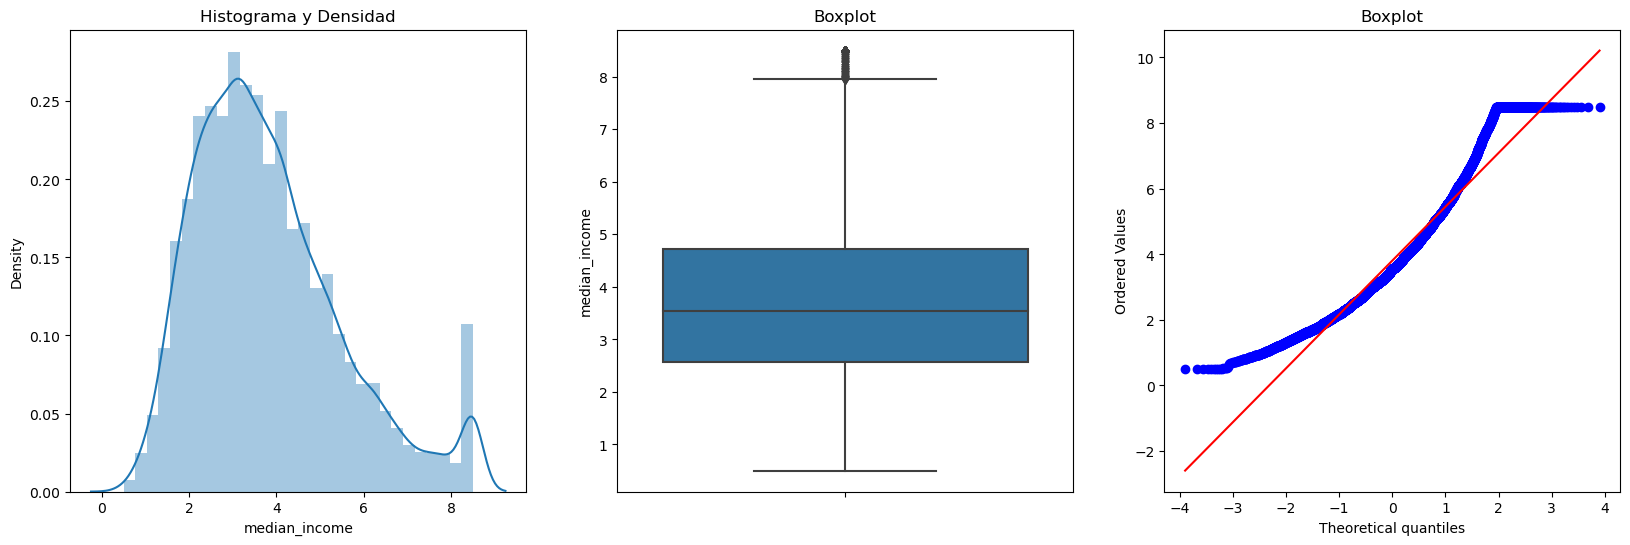

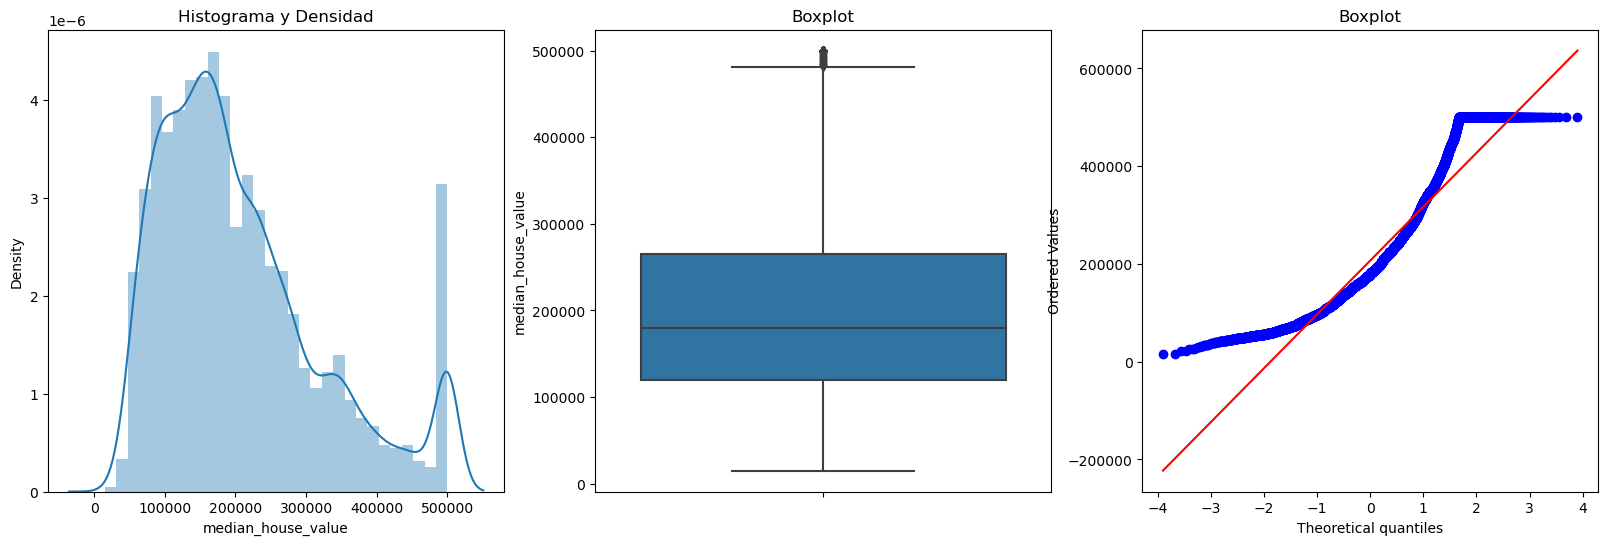

In [92]:
for col in continuas: 
    plotDistBoxQQ(dataHP,col)

### Feature Scaling

In [102]:
from sklearn.preprocessing import StandardScaler

In [104]:
dataHP_temp=dataHP.copy()[continuas]

In [105]:
scaler = StandardScaler()
scaler.fit(dataHP_temp)#Calculamos información interna (parametros) para transformaciones posteriores.

dataHP_scaled = scaler.transform(dataHP_temp)
dataHP_scaled = pd.DataFrame(dataHP_scaled,columns=dataHP_temp.columns)

In [106]:
round(dataHP_scaled.describe(),2)

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14447.00,14447.0,14447.00,14447.00,14447.00,14310.00,14447.00,14447.00,14447.00,14447.00
mean,-0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
std,1.00,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.72,0.0,-1.45,-2.21,-1.69,-1.69,-1.69,-1.71,-1.96,-1.66
25%,-0.86,0.0,-0.80,-0.86,-0.70,-0.71,-0.71,-0.70,-0.74,-0.76
50%,-0.01,0.0,-0.65,0.01,-0.23,-0.25,-0.23,-0.24,-0.16,-0.24
75%,0.87,0.0,0.97,0.65,0.47,0.47,0.47,0.48,0.54,0.50
max,1.74,0.0,2.95,1.84,2.51,2.53,2.53,2.54,2.78,2.54


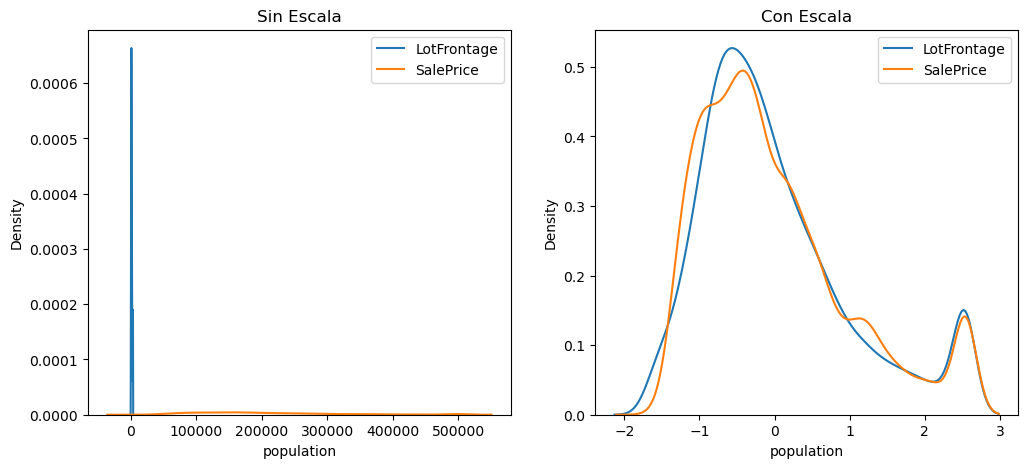

In [107]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

ax1.set_title("Sin Escala")
sns.kdeplot(dataHP['population'],ax=ax1,label="LotFrontage")
sns.kdeplot(dataHP['median_house_value'],ax=ax1,label="SalePrice")

ax2.set_title("Con Escala")
sns.kdeplot(dataHP_scaled['population'],ax=ax2,label="LotFrontage")
sns.kdeplot(dataHP_scaled['median_house_value'],ax=ax2,label="SalePrice")

ax1.legend()
ax2.legend()

plt.show()


####  Separamos datos de entrenamiento y prueba 


In [157]:
X_train, X_test, y_train, y_test = train_test_split(
    dataHP.drop(['id', 'median_house_value'], axis=1),
    dataHP['median_house_value'],
    test_size=0.3,
    random_state=2022)

### Configuración y construcción del Pipeline

In [161]:
# Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['ocean_proximity']

# Variables a utilizar en el entrenamiento
FEATURES = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'population',
    'households',
    'median_income',
    'ocean_proximity'
]

X_train = X_train[FEATURES]

y_train = np.log(y_train)
y_test = np.log(y_test)

housePrice_pipeline_v08062023 = Pipeline([
    # ============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ================
    ('rare_label_encoder',
        RareLabelEncoder(n_categories=1, tol=0.01, variables=CATEGORICAL_VARS)
    ),
    ('categorical_encoder',
        OrdinalEncoder(encoding_method='ordered', variables=CATEGORICAL_VARS)
    ),
    # =============== TRANSFORMACIÓN DE VARIABLES CONTINUAS ============
    ('scaler',
        MinMaxScaler()
    ),
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2022)
    )
])



In [163]:
X_train = X_train[FEATURES]

In [165]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [166]:
housePrice_pipeline_v08062023.fit(X_train, y_train) 


Pipeline(steps=[('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['ocean_proximity'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2022))])

In [167]:
X_test = X_test[FEATURES]

In [168]:
preds = housePrice_pipeline_v08062023.predict(X_test)

In [169]:
rmseTest = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds)))
rmseTest

0.019013313705933736

In [170]:
np.min(np.exp(y_train)), np.max(np.exp(y_train))

(0.816868644585276, 0.9455846661006008)

In [171]:
rmseTest / (np.max(np.exp(y_train)) - np.min(np.exp(y_train)))

0.1477152065616791

### Guardamos el pipeline para uso en producción 

In [172]:
#guardamos pipeline para uso en producción.
joblib.dump(housePrice_pipeline_v08062023, 'housePrice_pipeline_v08062023.pkl')

['housePrice_pipeline_v08062023.pkl']

In [173]:
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']